In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from pylab import *

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector, Flatten,Dropout
from keras.layers import TimeDistributed
from sklearn.metrics import mean_squared_error

In [2]:

df= pd.read_csv("DF.csv",parse_dates=['Recording start time'], index_col='Recording start time')

df.drop('Unnamed: 0',axis = 1,inplace=True)

In [31]:
def datacreation(Timeline):
  window  = 40   #time series length
  skip    = 1
  next    = 15    #predict point in next steps

  x_data = []
  y_data = [] 

  for i in range( 0, len(Timeline) - window - next, skip ):
    x_data.append( Timeline[i:i+window] )
    y_data.append( Timeline[i+window+next] )

  x_data_np = np.array(x_data)
  y_data_np = np.array(y_data)

  print("x_data_np", x_data_np.shape,"y_data_np", y_data_np.shape)
  return x_data_np,y_data_np

In [32]:
def data_engineering(x_data_np,y_data_np):
  #normalize
  scaler = StandardScaler()
  x_data,y_data = [],[]
  for i in range(x_data_np.shape[2]):
    x_data.append(scaler.fit_transform(x_data_np[:,:,i]))
    y_data.append(scaler.fit_transform(y_data_np[:,i].reshape(-1,1)))
  # exapnad dim
  for i in range(np.array(x_data).shape[0]):
    x_data[i] = x_data[i].reshape((x_data[i].shape[0],x_data[i].shape[1],1))
    y_data[i] = y_data[i].reshape((y_data[i].shape[0],1))


  # #final array normalized
  x_data = np.concatenate((x_data),axis=2)
  y_data = np.concatenate((y_data),axis=1)


  #Check correctness
  print("y_data", y_data.shape,"x_data", x_data.shape)
  return x_data,y_data


In [33]:
def train_split(x_data,y_data):
  #Train on the start of sequence ; test on the end of sequence
  index = int(x_data.shape[0]*0.8)

  X_train = x_data[:index,:,:]
  X_val = x_data[index:,:,:]

  Y_train = y_data[:index,:]
  Y_val = y_data[index:,:] 

  print('Train set shape', X_train.shape)
  print('Validation set shape', X_val.shape)
  print("y_train set shape",Y_train.shape)
  print('Validation label shape', Y_val.shape)
  return X_train,X_val,Y_train,Y_val

In [34]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Activation
import tensorflow.keras
import tensorflow
from tensorflow.keras.regularizers import L1L2
from collections import UserDict, deque

In [51]:
def conv_1D(X_train,Y_train):

    
    #Encoder CNN Part 

    model = Sequential([

    Conv1D(input_shape = (X_train.shape[1], X_train.shape[2]), filters = 32,  kernel_size = 5),
    ELU(),
    SpatialDropout1D(0.1),
    MaxPooling1D(pool_size= 2),



    Conv1D(filters = 64 , kernel_size = 5),
    ELU(),
    SpatialDropout1D(0.1),
    MaxPooling1D(pool_size= 2),


    Conv1D(filters = 32,  kernel_size = 5),
    ELU(),
    SpatialDropout1D(0.1),
    MaxPooling1D(pool_size= 2),


    Flatten(),


    #Decoder LSTM part
    RepeatVector(X_train.shape[2]),
	  LSTM(300, return_sequences=True),
	  TimeDistributed(Dense(Y_train.shape[1])),

    Flatten(),
    Dense(150),

    Dense(Y_train.shape[1], activation = "linear", kernel_initializer = 'normal')
    ])
   

    #Compile the model
    model.compile(loss = "mse", optimizer = "adam")
        
    return model

In [52]:
Timeline = df.loc[(df['Participant name']==2) | (df['Participant name'] ==3) | (df['Participant name'] ==6)| (df['Participant name'] ==7)]

In [53]:
Timeline =Timeline.iloc[:,4:]
Timeline.shape

(5266, 4)

In [54]:
Timeline=np.array(Timeline)

In [55]:
x_data_np,y_data_np= datacreation(Timeline)
x_data,y_data = data_engineering(x_data_np,y_data_np)
X_train,X_val,Y_train,Y_val = train_split(x_data,y_data) 
model_lstm = conv_1D(X_train,Y_train)
lstm_history = model_lstm.fit(X_train, Y_train, validation_data=(X_val, Y_val),
epochs=100, verbose=2,batch_size = 16,
callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)])

x_data_np (5211, 40, 4) y_data_np (5211, 4)
y_data (5211, 4) x_data (5211, 40, 4)
Train set shape (4168, 40, 4)
Validation set shape (1043, 40, 4)
y_train set shape (4168, 4)
Validation label shape (1043, 4)
Epoch 1/100
261/261 - 12s - loss: 0.4633 - val_loss: 0.1542 - 12s/epoch - 44ms/step
Epoch 2/100
261/261 - 6s - loss: 0.3667 - val_loss: 0.1350 - 6s/epoch - 22ms/step
Epoch 3/100
261/261 - 6s - loss: 0.3507 - val_loss: 0.1558 - 6s/epoch - 21ms/step
Epoch 4/100
261/261 - 6s - loss: 0.3224 - val_loss: 0.1530 - 6s/epoch - 23ms/step
Epoch 5/100
261/261 - 6s - loss: 0.3095 - val_loss: 0.1925 - 6s/epoch - 23ms/step
Epoch 6/100
261/261 - 6s - loss: 0.2902 - val_loss: 0.2007 - 6s/epoch - 23ms/step
Epoch 7/100
261/261 - 6s - loss: 0.2779 - val_loss: 0.2038 - 6s/epoch - 23ms/step
Epoch 8/100
261/261 - 6s - loss: 0.2671 - val_loss: 0.3065 - 6s/epoch - 23ms/step
Epoch 9/100
261/261 - 6s - loss: 0.2544 - val_loss: 0.2308 - 6s/epoch - 23ms/step
Epoch 10/100
261/261 - 6s - loss: 0.2348 - val_loss:

In [56]:
loss = model_lstm.evaluate(X_val, Y_val, verbose=0)
print('MAE: %f' % loss)


MAE: 0.135013


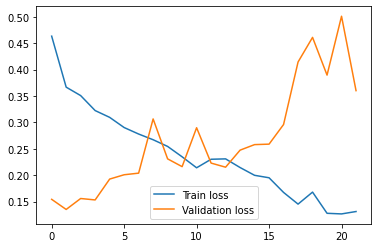

In [57]:
plot(lstm_history.history['loss'], label='Train loss')
plot(lstm_history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

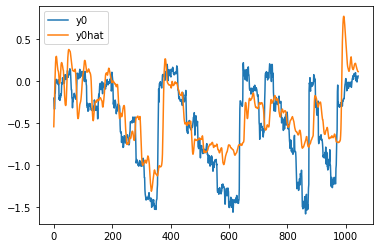

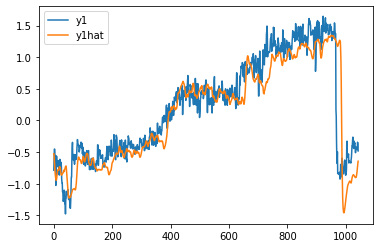

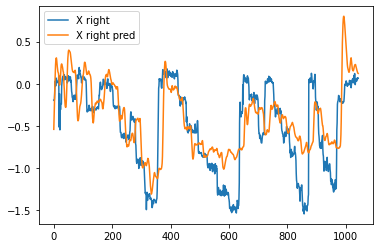

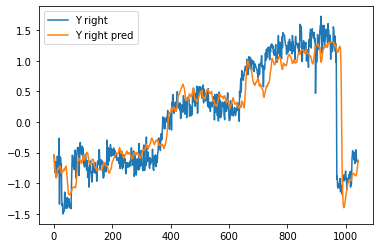

In [58]:
#X left  axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,0], label='y0')
plt.plot(yhat[:,0], label='y0hat')
plt.legend()
plt.show()

#Y left axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,1], label='y1')
plt.plot(yhat[:,1], label='y1hat')
plt.legend()
plt.show()

#X right axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,2], label='X right')
plt.plot(yhat[:,2], label='X right pred')
plt.legend()
plt.show()

#Y right axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,3], label='Y right')
plt.plot(yhat[:,3], label='Y right pred')
plt.legend()
plt.show()
